# Training loss and validation values comparison

In [1]:
%run __common.py
%load_ext autoreload
%autoreload 2

Provided checkpoint directory /iopsstor/scratch/cscs/stefschu/DSM500/github/analysis/checkpoints does not exist, skipping load


Loaded validation datapipe of size 6


## Preamble: the area weights and `normalized_grid_cell_area()` function

Defined under `examples/weather/graphcast/loss/utils.py` it produces weight based on the latitude.

In [2]:
lat_lon_grid = trainer.model.lat_lon_grid
print(lat_lon_grid.shape)

lat_lon_grid[0:2, 0:2]

torch.Size([721, 1440, 2])


tensor([[[ -90.0000, -179.7500],
         [ -90.0000, -179.5000]],

        [[ -89.7500, -179.7500],
         [ -89.7500, -179.5000]]])

From the training script, area is defined as:

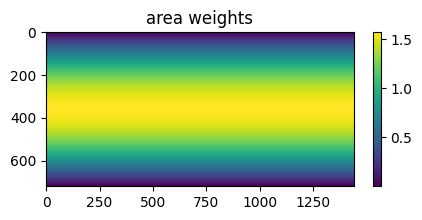

In [3]:
area = normalized_grid_cell_area(lat_lon_grid[:, :, 0], unit="deg")

plt.figure(figsize=(5, 2))
plt.imshow(area)
plt.colorbar()
plt.title("area weights")
plt.show()

These area values are weights to give less importance to the poles.

## Preamble: the loss function and the `CellAreaWeightedLossFunction()` class

Defined in `modulus/utils/graphcast/loss.py` (here simplified for readability):

<div style="font-size: 10px; border: 1px solid black; padding: 10px; margin-top: 15px; margin-bottom: 15px; border-radius: 5px; max-width: 900px;">

```python
class GraphCastLossFunction(nn.Module):
    def __init__(self, area, channels_list, dataset_metadata_path, time_diff_std_path):
        self.area = area
        self.channel_dict = self.get_channel_dict(dataset_metadata_path, channels_list)
        self.variable_weights = self.assign_variable_weights()
        self.time_diff_std = self.get_time_diff_std(time_diff_std_path, channels_list)

    def forward(self, invar, outvar):
        """
        Implicit forward function which computes the loss given a prediction and the corresponding targets.
        """
        loss = (invar - outvar) ** 2  # [T,C,H,W]

        # weighted by inverse variance
        loss = (
            loss
            * 1.0
            / torch.square(self.time_diff_std.view(1, -1, 1, 1).to(loss.device))
        )

        # weighted by variables
        variable_weights = self.variable_weights.view(1, -1, 1, 1).to(loss.device)
        loss = loss * variable_weights  # [T,C,H,W]

        # weighted by area
        loss = loss.mean(dim=(0, 1))
        loss = torch.mul(loss, self.area)
        loss = loss.mean()

        return loss

    def get_time_diff_std(self, time_diff_std_path, channels_list):
        """Gets the time difference standard deviation"""
        time_diff_np = np.load(time_diff_std_path)
        return time_diff_np[:, channels_list, ...]

    def get_channel_dict(self, dataset_metadata_path, channels_list):
        """Gets lists of surface and atmospheric channels"""
        with open(dataset_metadata_path, "r") as f:
            data_json = json.load(f)
            channel_list = [data_json["coords"]["channel"][c] for c in channels_list]
            channel_dict = {"surface": [], "atmosphere": []}
            for each_channel in channel_list:
                if each_channel[-1].isdigit():
                    channel_dict["atmosphere"].append(each_channel)
                else:
                    channel_dict["surface"].append(each_channel)
            return channel_dict

    def parse_variable(self, variable_list):
        """Parse variable into its letter and numeric parts."""
        for i, char in enumerate(variable_list):
            if char.isdigit():
                return variable_list[:i], int(variable_list[i:])

    def calculate_linear_weights(self, variables):
        """Calculate weights for each variable group."""
        groups = defaultdict(list)
        # Group variables by their first letter
        for variable in variables:
            letter, number = self.parse_variable(variable)
            groups[letter].append((variable, number))
        # Calculate weights for each group
        weights = {}
        for values in groups.values():
            total = sum(number for _, number in values)
            for variable, number in values:
                weights[variable] = number / total
        return weights

    def assign_surface_weights(self):
        """Assigns weights to surface variables"""
        surface_weights = {i: 0.1 for i in self.channel_dict["surface"]}
        if "t2m" in surface_weights:
            surface_weights["t2m"] = 1
        return surface_weights

    def assign_atmosphere_weights(self):
        """Assigns weights to atmospheric variables"""
        return self.calculate_linear_weights(self.channel_dict["atmosphere"])

    def assign_variable_weights(self):
        """assigns per-variable per-pressure level weights"""
        surface_weights_dict = self.assign_surface_weights()
        atmosphere_weights_dict = self.assign_atmosphere_weights()
        surface_weights = list(surface_weights_dict.values())
        atmosphere_weights = list(atmosphere_weights_dict.values())
        variable_weights = torch.cat(
            (torch.FloatTensor(surface_weights), torch.FloatTensor(atmosphere_weights))
        )  # [num_channel]
        return variable_weights
```
</div>

<div style="padding: 10px; background-color: #ffcc00; color: black; border-radius: 5px;">
  <strong>Warning:</strong> The time_diff_std is squared and moved to the GPU every time the loss is computed. This is a small and static array. There seem to be no need to keep moving it. It can be optimied by moving data only at setup.
</div>

> Fixed as part of https://github.com/schuups/DSM500/commit/5a37f9003ffc551e34dc4af2541e0f6432dcad34

Reviewing the object initialization, area, channels and time_diff_std are trivial to understand:

In [4]:
from modulus.utils.graphcast.loss import GraphCastLossFunction
dtype = torch.bfloat16 if cfg.full_bf16 else torch.float32
device = dist.device
criterion = GraphCastLossFunction(area.to(dist.device), channels_list, cfg.dataset_metadata_path, cfg.time_diff_std_path, dtype, device)
criterion.channel_dict

{'original_order': ['10u',
  '10v',
  't2m',
  'sp',
  'msl',
  't_850',
  'u_1000',
  'v_1000',
  'z_1000',
  'u_850',
  'v_850',
  'z_850',
  'u_500',
  'v_500',
  'z_500',
  't_500',
  'z_50',
  'r_500',
  'r_850',
  'tcwv',
  'sst'],
 'surface': ['10u', '10v', 't2m', 'sp', 'msl', 'tcwv', 'sst'],
 'atmosphere': ['t_850',
  'u_1000',
  'v_1000',
  'z_1000',
  'u_850',
  'v_850',
  'z_850',
  'u_500',
  'v_500',
  'z_500',
  't_500',
  'z_50',
  'r_500',
  'r_850']}

Those are just grouped between surface or atmospheric.

`assign_variable_weights()` instead:
- surface variables are assigned weight 0.1 except for the temperature which is 1.0.
- atmospheric variables are assigned weights that sum up to 1 among all levels for that variable, with their weights based on their pressure level.
    - Levels closer to surface are given an higher weight.

In [5]:
for var_name, var_weight in zip(metadata["coords"]["channel"], np.squeeze(criterion.variable_weights)):
    print(f"{var_name}\t{var_weight:10.5f}")

TypeError: unsupported format string passed to Tensor.__format__

<div style="padding: 10px; background-color: #ffcc00; color: black; border-radius: 5px;">
  <strong>Warning:</strong> The metadata["coords"]["channel"] list the channels in the same order as they are stored in the dataset files. Yet, these weights are not aligned (see e.g. surface vars tcwv and sst).
</div>

> Fixed in https://github.com/schuups/DSM500/commit/b908d24183ef21b037478111bdca6a1cb488afce

In [13]:
criterion.time_diff_std, criterion.time_diff_std.shape

(tensor([[0.4141, 0.5471, 0.1488, 0.0265, 0.2020, 0.1065, 0.4120, 0.5456, 0.2043,
          0.3843, 0.5616, 0.1329, 0.3292, 0.5196, 0.0702, 0.1033, 0.0400, 0.6757,
          0.6950, 0.2118, 0.0025]]),
 torch.Size([1, 21]))

Now, looking specifically to how the loss value is computed:

<div style="font-size: 10px; border: 1px solid black; padding: 10px; margin-top: 15px; margin-bottom: 15px; border-radius: 5px; max-width: 900px;">

```python
class GraphCastLossFunction(nn.Module):
    ...
    
    def forward(self, invar, outvar):
        """
        Implicit forward function which computes the loss given a prediction and the corresponding targets.
        """
        loss = (invar - outvar) ** 2  # [T,C,H,W]

        # weighted by inverse variance
        loss = (
            loss
            * 1.0
            / torch.square(self.time_diff_std.view(1, -1, 1, 1).to(loss.device))
        )

        # weighted by variables
        variable_weights = self.variable_weights.view(1, -1, 1, 1).to(loss.device)
        loss = loss * variable_weights  # [T,C,H,W]

        # weighted by area
        loss = loss.mean(dim=(0, 1))
        loss = torch.mul(loss, self.area)
        loss = loss.mean()

        return loss
```
</div>

In [9]:
data = next(iter(trainer.datapipe))

In [10]:
invar = data[0]["invar"]
outvar = data[0]["outvar"]
cos_zenith = data[0]["cos_zenith"]
time_idx = data[0]["time_of_year_idx"].item()

invar_cat = prepare_input(
    invar,
    cos_zenith,
    num_history=cfg.num_history,
    static_data=trainer.static_data,
    step=1,
    time_idx=time_idx,
    stride=cfg.stride,
    dt=cfg.dt,
    num_samples_per_year=cfg.num_samples_per_year_train,
    device=dist.device,
)
invar_cat, outvar = invar_cat.to(dtype=trainer.dtype), outvar.to(dtype=trainer.dtype)
prediction = trainer.model(invar_cat)

invar_cat.shape, prediction.shape, outvar.shape

(torch.Size([1, 31, 721, 1440]),
 torch.Size([1, 21, 721, 1440]),
 torch.Size([1, 1, 21, 721, 1440]))

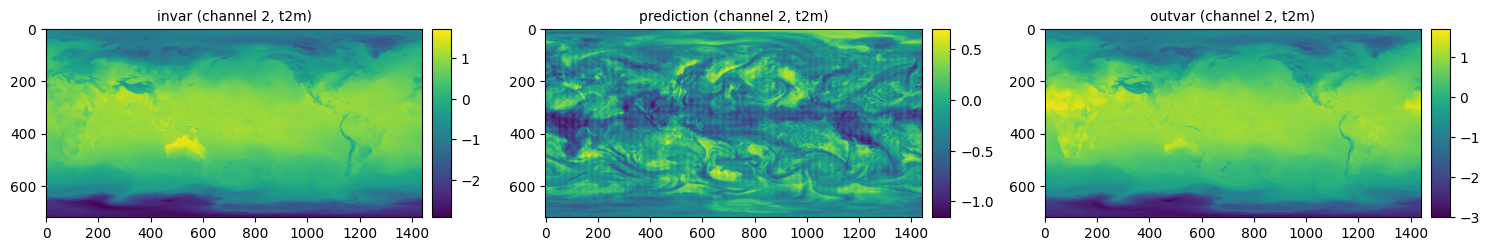

In [15]:
channel = 2

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
plot(invar_cat[0, channel].cpu().to(torch.float32).numpy(), f"invar (channel {channel}, {channel_names[channel]})", axs[0])
plot(prediction[0, channel].cpu().to(torch.float32).detach().numpy(), f"prediction (channel {channel}, {channel_names[channel]})", axs[1])
plot(outvar[0, 0, channel].cpu().to(torch.float32).numpy(), f"outvar (channel {channel}, {channel_names[channel]})", axs[2])

Dissecting the instructions making up the loss function:

In [14]:
invar = prediction

loss0 = (invar - outvar) ** 2  # [T,C,H,W]
print(loss0.shape)

print(f"Channel     {'Min':>20} {'Max':>20} {'Mean':>20} {'Std':>20}")
for c in range(loss0.shape[2]):
    print(f"Channel {c:2}: {loss0[0, 0, c].min():20.3f} {loss0[0, 0, c].max():20.3f} {loss0[0, 0, c].mean():20.3f} {loss0[0, 0, c].std():20.3f}")

torch.Size([1, 1, 21, 721, 1440])
Channel                      Min                  Max                 Mean                  Std
Channel  0:                0.000               17.500                1.086                1.688
Channel  1:                0.000               25.625                1.273                1.938
Channel  2:                0.000                7.125                1.141                1.266
Channel  3:                0.000               19.125                1.102                2.547
Channel  4:                0.000               22.000                1.031                1.836
Channel  5:                0.000                5.406                1.109                1.070
Channel  6:                0.000               12.375                1.109                1.539
Channel  7:                0.000               22.875                1.305                1.859
Channel  8:                0.000               17.750                1.227                1.680
Channe

In [17]:
inverse_variance_weights = 1.0 / torch.square(criterion.time_diff_std.view(1, -1, 1, 1))

print(f"Channel     {'Variable weight':>20}")
for c in range(loss0.shape[2]):
    print(f"Channel {c:2}: {inverse_variance_weights[0, c, 0, 0]:20.3f} {channel_names[c]}")

Channel          Variable weight
Channel  0:               33.750 10u
Channel  1:               11.188 10v
Channel  2:             2080.000 t2m
Channel  3:          2031616.000 sp
Channel  4:              600.000 msl
Channel  5:             7776.000 t_850
Channel  6:               34.500 u_1000
Channel  7:               11.188 v_1000
Channel  8:              576.000 z_1000
Channel  9:               45.500 u_850
Channel 10:               10.000 v_850
Channel 11:             3232.000 z_850
Channel 12:               84.500 u_500
Channel 13:               13.750 v_500
Channel 14:            40960.000 z_500
Channel 15:             8640.000 t_500
Channel 16:           391168.000 z_50
Channel 17:                4.781 r_500
Channel 18:                4.281 r_850
Channel 19:              496.000 tcwv
Channel 20:      23622320128.000 sst


In [19]:
# weighted by inverse variance
loss1 = (
    loss0
    * 1.0
    / torch.square(criterion.time_diff_std.view(1, -1, 1, 1).to(loss0.device))
)

print(f"Channel     {'Min':>20} {'Max':>20} {'Mean':>20} {'Std':>20} {'Weight':>20}")
for c in range(loss1.shape[2]):
    print(f"Channel {c:2}: {loss1[0, 0, c].min():20.3f} {loss1[0, 0, c].max():20.3f} {loss1[0, 0, c].mean():20.3f} {loss1[0, 0, c].std():20.3f} {inverse_variance_weights[0, c, 0, 0]:20.3f}")

Channel                      Min                  Max                 Mean                  Std               Weight
Channel  0:                0.000              592.000               36.750               57.250               33.750
Channel  1:                0.000              286.000               14.250               21.625               11.188
Channel  2:                0.000            14784.000             2368.000             2624.000             2080.000
Channel  3:                0.000         38797312.000          2228224.000          5177344.000          2031616.000
Channel  4:                0.000            13248.000              620.000             1104.000              600.000
Channel  5:                0.000            41984.000             8640.000             8320.000             7776.000
Channel  6:                0.000              428.000               38.500               53.000               34.500
Channel  7:                0.000              256.000           

<div style="padding: 10px; background-color: #ffcc00; color: black; border-radius: 5px;">
  <strong>Warning:</strong> The time_diff_std seems to overreppresent certain variables, giving them dominance on the loss computation.
</div>

In [21]:
# weighted by variables
variable_weights = criterion.variable_weights.view(1, -1, 1, 1).to(loss1.device)

print(f"Channel     {'Weight':>20}")
for c in range(loss1.shape[2]):
    print(f"Channel {c:2}: {variable_weights[0, c, 0, 0]:20.3f} {channel_names[c]}")

Channel                   Weight
Channel  0:                0.100 10u
Channel  1:                0.100 10v
Channel  2:                1.000 t2m
Channel  3:                0.100 sp
Channel  4:                0.100 msl
Channel  5:                0.629 t_850
Channel  6:                0.426 u_1000
Channel  7:                0.426 v_1000
Channel  8:                0.416 z_1000
Channel  9:                0.361 u_850
Channel 10:                0.361 v_850
Channel 11:                0.354 z_850
Channel 12:                0.213 u_500
Channel 13:                0.213 v_500
Channel 14:                0.208 z_500
Channel 15:                0.371 t_500
Channel 16:                0.021 z_50
Channel 17:                0.371 r_500
Channel 18:                0.629 r_850
Channel 19:                0.100 tcwv
Channel 20:                0.100 sst


In [22]:
loss2 = loss1 * variable_weights  # [T,C,H,W]

print(f"Channel     {'Min':>20} {'Max':>20} {'Mean':>20} {'Std':>20} {'Weight':>20}")
for c in range(loss2.shape[2]):
    print(f"Channel {c:2}: {loss2[0, 0, c].min():20.3f} {loss2[0, 0, c].max():20.3f} {loss2[0, 0, c].mean():20.3f} {loss2[0, 0, c].std():20.3f} {variable_weights[0, c, 0, 0]:20.3f}")

Channel                      Min                  Max                 Mean                  Std               Weight
Channel  0:                0.000               59.250                3.688                5.719                0.100
Channel  1:                0.000               28.625                1.430                2.172                0.100
Channel  2:                0.000            14784.000             2368.000             2624.000                1.000
Channel  3:                0.000          3883008.000           223232.000           520192.000                0.100
Channel  4:                0.000             1328.000               62.250              110.500                0.100
Channel  5:                0.000            26368.000             5440.000             5216.000                0.629
Channel  6:                0.000              182.000               16.375               22.625                0.426
Channel  7:                0.000              109.000           

In [23]:
loss3 = loss2.mean(dim=(0, 1))
print(loss3.shape)

print(f"Channel     {'Min':>20} {'Max':>20} {'Mean':>20} {'Std':>20}")
for c in range(loss3.shape[0]):
    print(f"Channel {c:2}: {loss3[c].min():20.3f} {loss3[c].max():20.3f} {loss3[c].mean():20.3f} {loss3[c].std():20.3f}")

torch.Size([21, 721, 1440])
Channel                      Min                  Max                 Mean                  Std
Channel  0:                0.000               59.250                3.688                5.719
Channel  1:                0.000               28.625                1.430                2.172
Channel  2:                0.000            14784.000             2368.000             2624.000
Channel  3:                0.000          3883008.000           223232.000           520192.000
Channel  4:                0.000             1328.000               62.250              110.500
Channel  5:                0.000            26368.000             5440.000             5216.000
Channel  6:                0.000              182.000               16.375               22.625
Channel  7:                0.000              109.000                6.219                8.875
Channel  8:                0.000             4224.000              294.000              402.000
Channel  9: 

In [24]:
loss4 = torch.mul(loss3, criterion.area)
print(loss4.shape)

print(f"Channel     {'Min':>20} {'Max':>20} {'Mean':>20} {'Std':>20}")
for c in range(loss3.shape[0]):
    print(f"Channel {c:2}: {loss4[c].min():20.3f} {loss4[c].max():20.3f} {loss4[c].mean():20.3f} {loss4[c].std():20.3f}")

torch.Size([21, 721, 1440])
Channel                      Min                  Max                 Mean                  Std
Channel  0:                0.000               71.000                3.516                5.906
Channel  1:                0.000               33.500                1.234                2.125
Channel  2:                0.000            16640.000             2240.000             2848.000
Channel  3:                0.000          5308416.000           134144.000           284672.000
Channel  4:                0.000             1456.000               44.000               77.500
Channel  5:                0.000            35840.000             4672.000             4704.000
Channel  6:                0.000              258.000               15.625               23.375
Channel  7:                0.000              160.000                5.812                9.188
Channel  8:                0.000             4608.000              239.000              350.000
Channel  9: 

In [25]:
loss4.mean()

tensor(1.1587e+08, device='cuda:0', dtype=torch.bfloat16,
       grad_fn=<MeanBackward0>)

<div style="padding: 10px; background-color: #ffcc00; color: black; border-radius: 5px;">
  <strong>Warning:</strong> The loss value is clearly dominated by the sst (channel 20), primarily due to the inverse variance!
</div>

## Preamble: the validation step defined in the  `Validation()` class

As defined in `examples/weather/graphcast/validation_base.py` (simplified here for readability):


<div style="font-size: 10px; border: 1px solid black; padding: 10px; margin-top: 15px; margin-bottom: 15px; border-radius: 5px; max-width: 900px;">

```python
class Validation:
    def __init__(self, cfg: DictConfig, model, dtype, dist, static_data):
        self.model = model
        self.val_datapipe = ERA5HDF5Datapipe(
            data_dir=os.path.join(cfg.dataset_path, "test"),
            stats_dir=os.path.join(cfg.dataset_path, "stats"),
            channels=[i for i in range(cfg.num_channels_climate)],
            num_steps=cfg.num_val_steps,
            use_cos_zenith={
                "dt": 6.0,
                "start_year": 2016,
            },
            num_samples_per_year=cfg.num_val_spy,
            ...
        )
        print(f"Loaded validation datapipe of size {len(self.val_datapipe)}")
        
    def step(self, channels=[0, 1, 2], iter=0, time_idx=None, generate_plots=True):
        loss_epoch = 0
        for i, data in enumerate(self.val_datapipe):
            invar = data[0]["invar"]
            outvar = data[0]["outvar"][0]
            cos_zenith = data[0]["cos_zenith"]
            time_idx = data[0]["time_of_year_idx"].item()
            
            invar_cat = prepare_input(
                invar=invar,
                cos_zenith=cos_zenith,
                time_idx=time_idx,
                step=1,
            )

            pred = torch.empty(outvar.shape)
            for t in range(outvar.shape[0]):
                outpred = self.model(invar_cat)
                pred[t] = outpred
                invar = outpred
                invar_cat = prepare_input(
                    invar=invar,
                    cos_zenith=cos_zenith,
                    time_idx=time_idx,
                    step=t + 2,
                )
                invar_cat = invar_cat.to(dtype=self.dtype)

            loss_epoch += torch.mean(torch.pow(pred - outvar, 2))

            if generate_plots:
                ...

        return loss_epoch / len(self.val_datapipe)
```
</div>

<div style="padding: 10px; background-color: #ffcc00; color: black; border-radius: 5px;">
  <strong>Warning:</strong> The cos_zenith_args dict is configured to start from 2017, while testing data is available from 2016.
</div>

## The issue

The training loss metric and the validation MSE metric, as published to wandb, are not comparable.



During training the two metrics are computed in `examples/weather/graphcast/train_graphcast.py` as follows (simplified for reading):

<div style="font-size: 10px; border: 1px solid black; padding: 10px; margin-top: 15px; margin-bottom: 15px; border-radius: 5px; max-width: 900px;">

```python
class GraphCastTrainer(BaseTrainer):
    def __init__(self, cfg: DictConfig, dist, rank_zero_logger):
        ...
        self.channels_list = [i for i in range(cfg.num_channels_climate)]
        ...

        self.area = normalized_grid_cell_area(self.lat_lon_grid[:, :, 0], unit="deg")

        self.criterion = GraphCastLossFunction(
            self.area,
            self.channels_list,
            cfg.dataset_metadata_path,
            cfg.time_diff_std_path,
        )
        
        if dist.rank == 0:
            self.validation = Validation(cfg, self.model, self.dtype, self.dist, self.static_data)
        else:
            self.validation = None

def main(cfg: DictConfig) -> None:
    ...
    trainer = GraphCastTrainer(cfg, dist, rank_zero_logger)
    loss_agg = 0
    iter = 0    
    while True:
        for _, data in enumerate(trainer.datapipe):
            ...
            # Prepare the input & output
            invar = data[0]["invar"]
            outvar = data[0]["outvar"]
            cos_zenith = data[0]["cos_zenith"]
            time_idx = data[0]["time_of_year_idx"].item()
            
            invar_cat = prepare_input(
                invar,
                cos_zenith,
                time_idx=time_idx,
                step=1,
                ...
            )

            # training step
            loss = trainer.train(invar_cat, outvar)
            if dist.rank == 0:
                loss_agg += loss.detach().cpu()

            # validation
            if trainer.validation and iter % cfg.val_freq == 0:
                error = trainer.validation.step(
                    channels=list(np.arange(cfg.num_channels_val)), 
                    iter=iter
                )
                logger.log(f"iteration {iter}, Validation MSE: {error:.04f}")
                wandb.log({"Validation MSE": error}, step=iter}
            # distributed barrier
            if dist.world_size > 1:
                torch.distributed.barrier()

            # print logs and save checkpoint
            if dist.rank == 0 and iter % cfg.save_freq == 0:
                loss_all = loss_agg / cfg.save_freq
                logger.log(f"iteration: {iter}, loss: {loss_all:10.3e},           time per iter: {iter_time:10.3e}")
                if dist.rank == 0:
                    wandb.log(
                        {
                            "loss": loss_all,
                            "learning_rate": trainer.scheduler.get_last_lr()[0],
                            "time_per_iter": iter_time,
                        },
                        step=iter,
                    )
                loss_agg = 0
            iter += 1

if __name__ == "__main__":
    main()
```
</div>


 loss value is computed in `examples/weather/graphcast/train_base.py` as follows:

<div style="font-size: 10px; border: 1px solid black; padding: 10px; margin-top: 15px; margin-bottom: 15px; border-radius: 5px; max-width: 900px;">

```python
class BaseTrainer:
    def rollout(self, grid_nfeat, y):
        total_loss = 0
        pred_prev = grid_nfeat
        for i in range(y.size(dim=1)):
            # Shape of y is [N, M, C, H, W]. M is the number of steps
            pred = self.model(pred_prev)
            loss = self.criterion(pred, y[:, i])
            total_loss += loss
            pred_prev = pred
        return total_loss

    def forward(self, grid_nfeat, y):
        loss = self.rollout(grid_nfeat, y)
        return loss

    def train(self, grid_nfeat, y):
        ..
        loss = self.forward(grid_nfeat, y)
        ...
        return loss
```
</div>